Consider the evolution of a simple Hamiltonian into a problem-specific Hamiltonian where the optimal solution is 'encoded' in the ground state of the problem Hamiltonian $\displaystyle \hat{\mathcal{H}}_{\text{P}}$

$$\hat{\mathcal{H}}\left(s\right) = \left(1 - s\right)\hat{\mathcal{H}}_0 + s\underbrace{\left(\hat{\mathcal{H}}_{\text{A}} + \hat{\mathcal{H}}_{\text{B}}\right)}_{\hat{\mathcal{H}}_{\text{P}}}$$

for some $\displaystyle s = \frac{t}{T}$ where $T$ is the total computation time and

$$\hat{\mathcal{H}}_0 = -h_0\sum_i\sigma_x^i$$

and

$$\hat{\mathcal{H}}_{\text{P}} = \alpha\left[\sum_{j = 0}^{M - 1}2^jy_j + \left(c + 1 - 2^M\right)y_M - \sum_{i = 1}^nw_ix_i\right]^2,\qquad S\left(n\right) = O\left(n + \left\lfloor\log_2c\right\rfloor + 1\right)$$

where $\displaystyle \alpha > \max\left(p_j\right)$ and $\displaystyle M = \left\lfloor\log_2c\right\rfloor$ s.t. $2^{\ell + 1} \leq c < 2^{M + 1}$


In [1]:
from qutip import Qobj, basis, expect, mesolve, qeye, sigmax, sigmaz, tensor
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(formatter={"all": lambda x: "{:.4g}".format(x)})

In [2]:
#   Tensor product such that i-th element is sigma_x and rest are identity
def tensor_sigmax(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = sigmax()
    return tensor(ops)


tensor_sigmax(0, 1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 1]
 [1 0]]

In [3]:
#   Tensor product such that i-th element is (I - sigma_z) / 2 and rest are identity
def tensor_sigmaz(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = (qeye(2) - sigmaz()) / 2
    return tensor(ops)


tensor_sigmaz(0, 1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0]
 [0 1]]

In [4]:
#   Parameters to set
profits = np.array([10, 2])
weights = np.array([1, 2])
capacity = 2

#   Derived parameters
num_items = profits.shape[0]
alpha = np.max(profits) + 1
M = int(np.floor(np.log2(capacity)))

total_qubits = num_items + M + 1
num_states = np.power(2, total_qubits)

print(
    f"Total qubits: {num_items} (no. of items) + {M + 1} (ancillary qubits) = {total_qubits}"
)

Total qubits: 2 (no. of items) + 2 (ancillary qubits) = 4


In [5]:
# #   Initial Hamiltonian H_0
# H_0 = sum(tensor_sigmaz(i, total_qubits) for i in range(total_qubits))
H_0 = sum(tensor_sigmax(i, total_qubits) for i in range(total_qubits))

H_0

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0]]

In [6]:
H_A1 = sum(
    np.power(2, j - num_items) * tensor_sigmaz(j, total_qubits)
    for j in range(num_items, num_items + M)
)  #   starting from the 1st ancillary qubit

H_A1

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

In [7]:
H_A2 = (capacity + 1 - np.power(2, M)) * tensor_sigmaz(num_items + M, total_qubits)

H_A2

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

In [8]:
H_A3 = -sum(weights[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_A3

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 -2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 -2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 -2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 -2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 -1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 -1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 -1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 -1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 -3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 -3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 -3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -3]]

In [9]:
#   Problem Hamiltonian H_P
H_A = (H_A1 + H_A2 + H_A3) ** 2

H_A

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

In [10]:
H_B = -sum(profits[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_B

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 -2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 -2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 -2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 -2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 -10 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 -10 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 -10 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 -10 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 -12 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 -12 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 -12 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -12]]

In [11]:
H_P = alpha * H_A + H_B

H_P

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 44 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 42 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 -2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 -10 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 -10 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 87 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 32 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 32 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1]]

In [12]:
eigenvalues, eigenstates = H_P.eigenstates()

np.sort(eigenvalues)

array([-10, -10, -2, -1, 0, 1, 1, 9, 9, 11, 11, 32, 32, 42, 44, 87])

In [13]:
#   Obtain the ground eigenstate of H_0
ground_eigenvalue, ground_eigenvector = H_0.groundstate()
psi0 = ground_eigenvector
print(f"Ground eigenvalue = {ground_eigenvalue}\nGround state:")

psi0

Ground eigenvalue = -4.0
Ground state:


Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.25]
 [-0.25]
 [-0.25]
 [0.25]
 [-0.25]
 [0.25]
 [0.25]
 [-0.25]
 [-0.25]
 [0.25]
 [0.25]
 [-0.25]
 [0.25]
 [-0.25]
 [-0.25]
 [0.25]]

In [14]:
times = np.linspace(0, 1, 10000)


#   Time-dependent Hamiltonian function
def H(s):
    return (1 - s) * H_0 + s * H_P

In [15]:
result = mesolve(H, psi0, times, e_ops=[])

psi_final = result.states[-1]

psi_final

Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.156+0.3064j]
 [0.06563-0.1416j]
 [0.06563-0.1416j]
 [-0.1299-0.06752j]
 [0.01413+0.1837j]
 [-0.2283+0.0868j]
 [-0.2283+0.0868j]
 [0.2095-0.3185j]
 [-0.08283-0.1092j]
 [0.3725-0.1216j]
 [0.3725-0.1216j]
 [-0.08099-0.1107j]
 [0.1009+0.1252j]
 [0.1717+0.03732j]
 [0.1717+0.03732j]
 [-0.06365+0.277j]]

In [16]:
def generate_basis_states(n):
    """Generates a list of all basis states for 'num_qubits' qubits."""
    return [
        tensor([basis(2, (i >> m) % 2) for m in range(n - 1, -1, -1)])
        for i in range(num_states)
    ]


basis_states = generate_basis_states(total_qubits)

print("Basis states generated!\n")

probabilities = []
energies = []

for psi in result.states:
    probs = [np.abs(basis_state.dag() * psi) ** 2 for basis_state in basis_states]
    probabilities.append(probs)

print("Probabilities computed!\n")

for time in times:
    H_t = H(time)
    e = [expect(H_t, basis_state) for basis_state in basis_states]
    energies.append(e)
    
print("Energies computed!\n")

Basis states generated!

Probabilities computed!

Energies computed!



In [17]:
final_probabilities = [
    (format(idx, f"0{total_qubits}b"), prob)
    for idx, prob in enumerate(probabilities[-1])
]
print("Final probabilities of each state:")
for state_label, prob in final_probabilities:
    print(f"| {state_label[0:num_items]} {state_label[num_items:]} >: {prob:.4f}")

Final probabilities of each state:
| 00 00 >: 0.1182
| 00 01 >: 0.0244
| 00 10 >: 0.0244
| 00 11 >: 0.0214
| 01 00 >: 0.0340
| 01 01 >: 0.0597
| 01 10 >: 0.0597
| 01 11 >: 0.1453
| 10 00 >: 0.0188
| 10 01 >: 0.1535
| 10 10 >: 0.1535
| 10 11 >: 0.0188
| 11 00 >: 0.0259
| 11 01 >: 0.0309
| 11 10 >: 0.0309
| 11 11 >: 0.0808


In [18]:
sorted_probabilities = sorted(final_probabilities, key=lambda x: x[1], reverse=True)
print("States with the highest probabilities:")
for state_label, prob in sorted_probabilities[:5]:
    print(f"| {state_label[0:num_items]} {state_label[num_items:]} >: {prob:.4f}")

States with the highest probabilities:
| 10 10 >: 0.1535
| 10 01 >: 0.1535
| 01 11 >: 0.1453
| 00 00 >: 0.1182
| 11 11 >: 0.0808


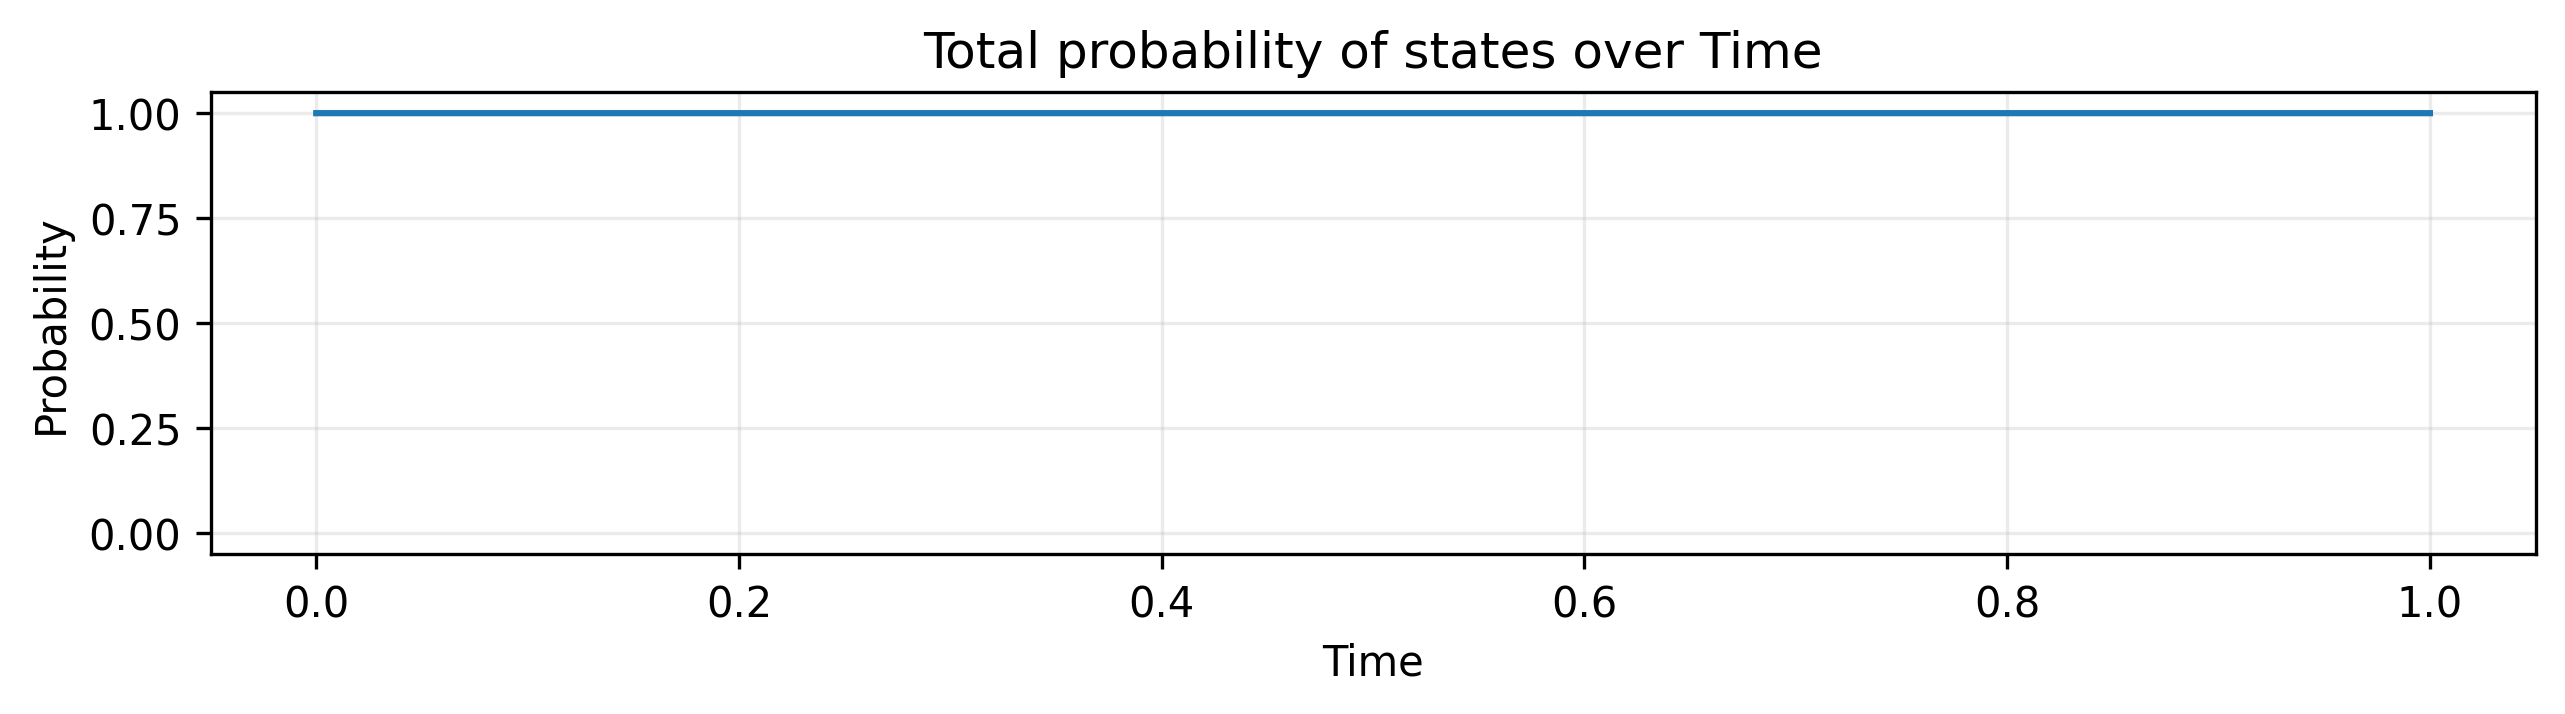

In [19]:
plt.figure(figsize=(10, 2), dpi=300)
plt.plot(
    times,
    [sum(prob) for prob in probabilities],
)

plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(-0.05, 1.05)
plt.title("Total probability of states over Time")
plt.grid(True, alpha=0.25)
plt.show()

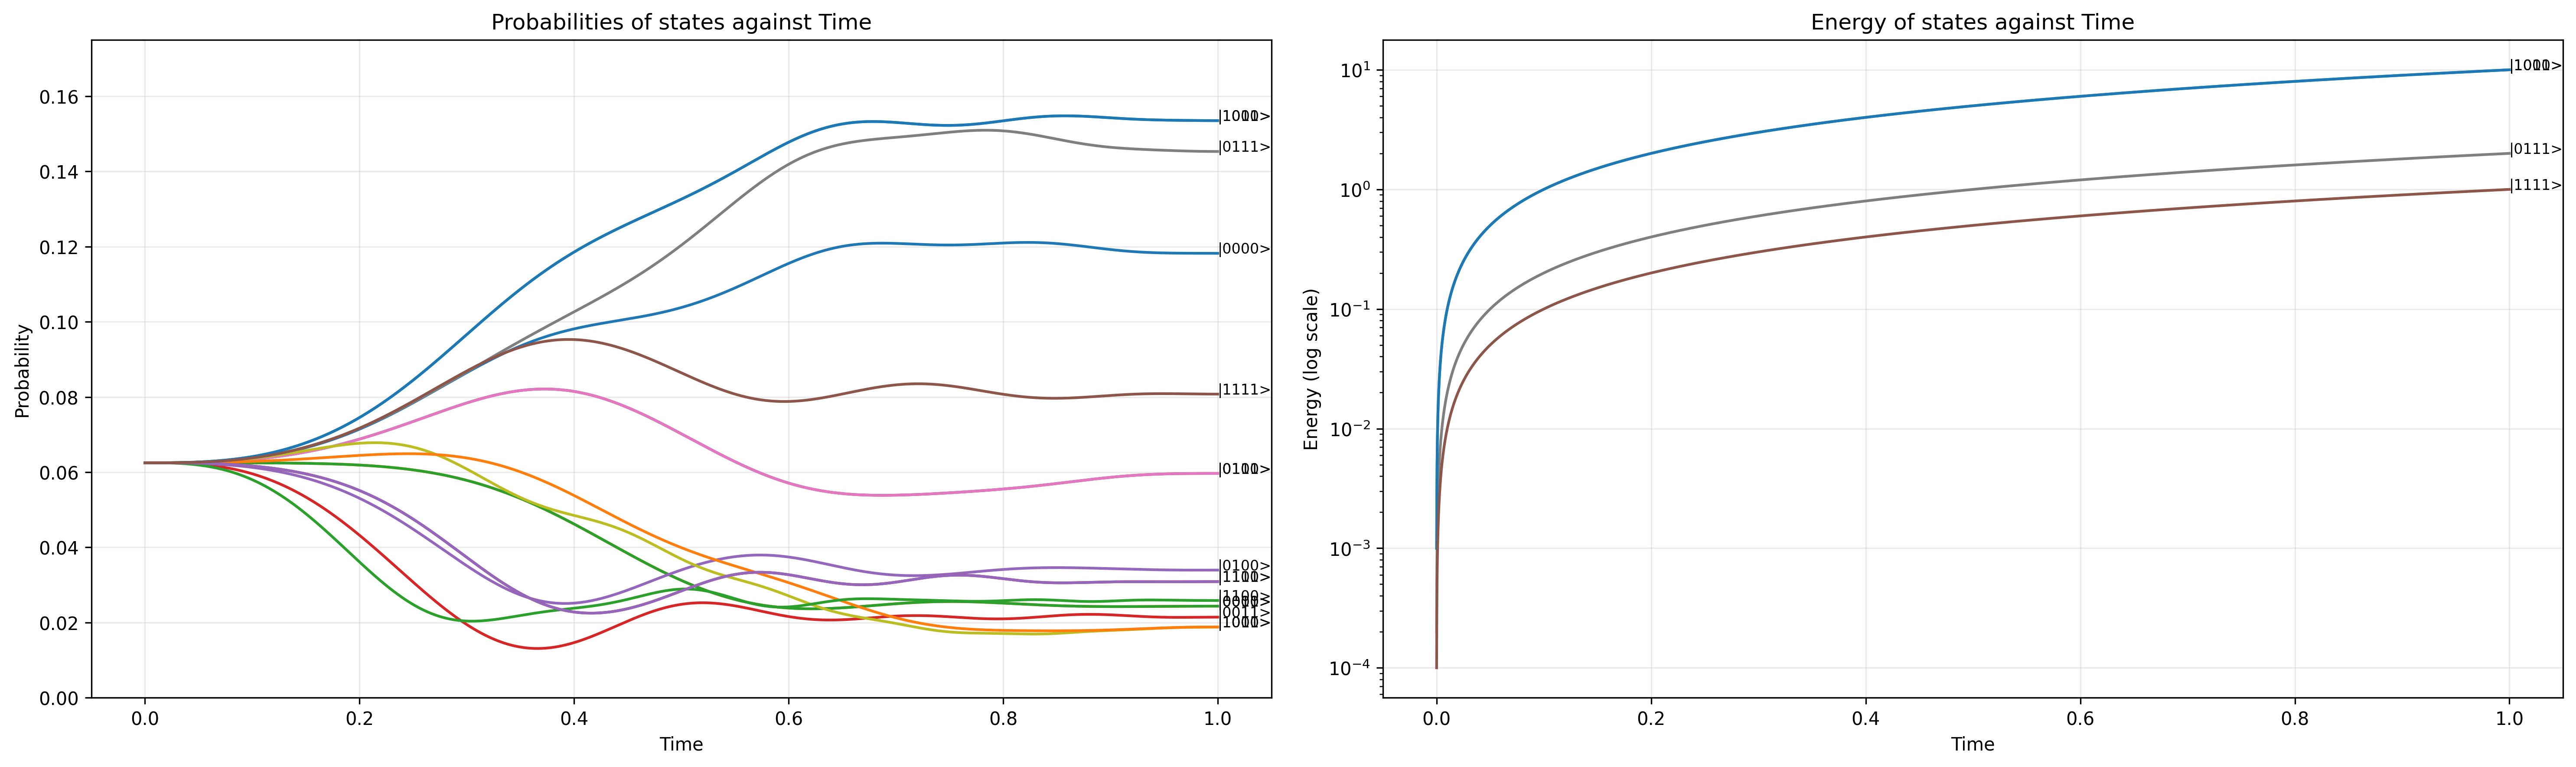

In [ ]:
# Filter and plot only negative energy values, and use a semilog plot for those negative values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=300)

# First plot: Probabilities over time
for idx in range(num_states):
    ax1.plot(
        times,
        [prob[idx] for prob in probabilities],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    ax1.text(
        times[-1],
        probabilities[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )

ax1.set(
    xlabel="Time",
    ylabel="Probability",
    ylim=(0, 0.175),
    title="Probabilities of states against Time",
)
ax1.grid(True, alpha=0.25)

# Second plot: Energies over time with negative values on a semilog plot
for idx in range(num_states):
    negative_energies = [-ener[idx] for ener in energies if ener[idx] < 0]
    ax2.semilogy(
        times[: len(negative_energies)],
        negative_energies,
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    if negative_energies:
        ax2.text(
            times[len(negative_energies) - 1],
            negative_energies[-1],
            f'|{format(idx, "0" + str(total_qubits) + "b")}>',
            fontsize=8,
        )

ax2.set(
    xlabel="Time", ylabel="Energy (log scale)", title="Energy of states against Time"
)
ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()